## Using Eleanor API to Identify resolve our Saturated Targets

The aim is to read in TIC ID's of the saturated targets (which are also likely 2-min target candidates) and download + compute the contents of `single_analysis_xrp.py` onto it, as the lightcurves from the Bucket use Eleanor's default apertures. This is fine for the most part, but as we have found out that Beta Pic's exocomets cannot be seen with these default apertures, we use an arbitrarily large aperture to expand the search instead.

In [1]:
import eleanor
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(eleanor.__path__)

['/home/astro/phrdhx/.local/lib/python3.7/site-packages/eleanor']


Standard aperture selected when bringing in lightcurve:

## Functions

In [3]:
def normalise_lc(flux):
    return flux/flux.mean()

## Eleanor lightcurves with default apertures

In [4]:
star = eleanor.Source(tic=270577175,sector=6) # beta pic
star_data = eleanor.TargetData(star, height=13, width=13, bkg_size=31, do_psf=True, do_pca=True)

INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_bkg.fits with expected size 61162560. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc.fits with expected size 122411520. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3_tess_v2_pm.txt with expected size 185294. [astroquery.query]




100%|██████████| 993/993 [00:11<00:00, 84.34it/s]


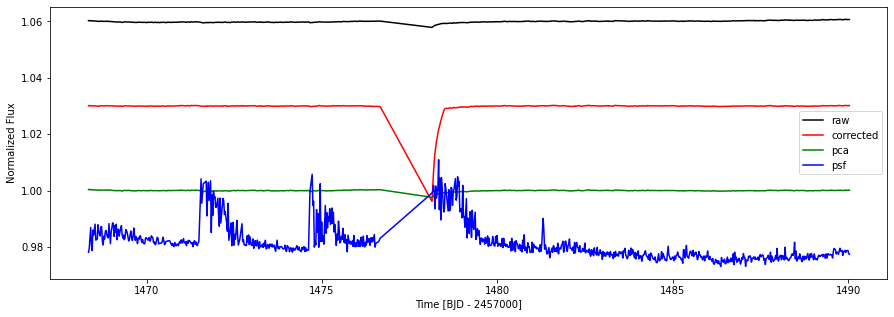

In [5]:
q = star_data.quality == 0
plt.figure(figsize=(15,5))


plt.plot(star_data.time[q], star_data.raw_flux[q]/np.nanmedian(star_data.raw_flux[q])+0.06, 'k',label='raw')
plt.plot(star_data.time[q], star_data.corr_flux[q]/np.nanmedian(star_data.corr_flux[q]) + 0.03, 'r',label='corrected')
plt.plot(star_data.time[q], star_data.pca_flux[q]/np.nanmedian(star_data.pca_flux[q]), 'g',label='pca')
plt.plot(star_data.time[q], star_data.psf_flux[q]/np.nanmedian(star_data.psf_flux[q]) - 0.02, 'b',label='psf')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.legend();

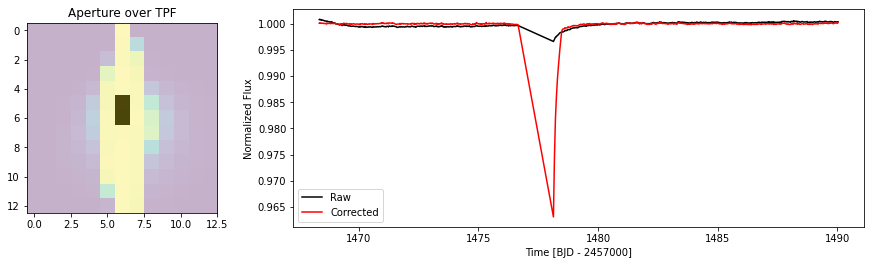

In [6]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax.imshow(star_data.tpf[0])
ax.imshow(star_data.all_apertures[0], cmap='Greys', alpha=0.7)
ax.set_title('Aperture over TPF')

ax1.plot(star_data.time[q], star_data.all_raw_flux[0][q]/np.nanmedian(star_data.all_raw_flux[0][q]), 'k', label='Raw')
ax1.plot(star_data.time[q], star_data.all_corr_flux[0][q]/np.nanmedian(star_data.all_corr_flux[0][q]), 'r', label='Corrected')
ax1.set_xlabel('Time [BJD - 2457000]')
ax1.set_ylabel('Normalized Flux')
ax1.legend();

### The chosen `Eleanor` aperture

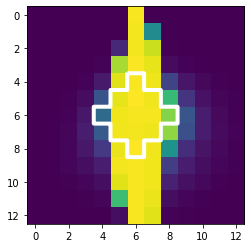

In [7]:
vis = eleanor.Visualize(star_data)
vis.aperture_contour()

## Custom Aperture

Text(0, 0.5, 'Normalized Flux')

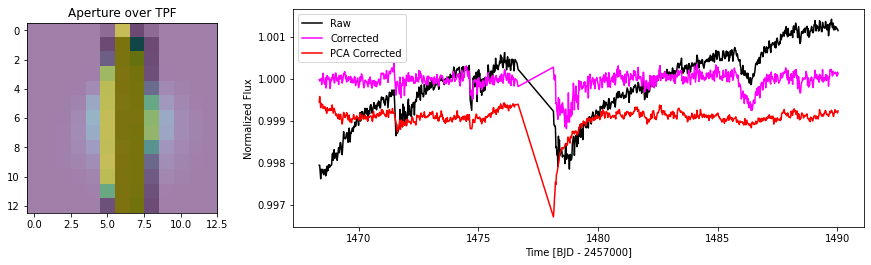

In [8]:
eleanor.TargetData.custom_aperture(star_data, shape='rectangle', h=13, w=3)
eleanor.TargetData.get_lightcurve(star_data)

fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax2.imshow(star_data.tpf[0])
ax2.imshow(star_data.aperture, cmap='Greys', alpha=0.5)
ax2.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax3.plot(star_data.time[q], star_data.raw_flux[q]/np.nanmedian(star_data.raw_flux[q]), 'black', label='Raw')
ax3.plot(star_data.time[q], star_data.corr_flux[q]/np.nanmedian(star_data.corr_flux[q]), 'magenta', label='Corrected')
ax3.plot(star_data.time[q], star_data.pca_flux[q]/np.nanmedian(star_data.pca_flux[q]) - 0.0009, 'r', label='PCA Corrected')
ax3.legend(loc='upper left')         
#ax2.set_ylim([0.997,1.001])
#ax2.set_xlim([1485,1487])
ax3.set_xlabel('Time [BJD - 2457000]')
ax3.set_ylabel('Normalized Flux')


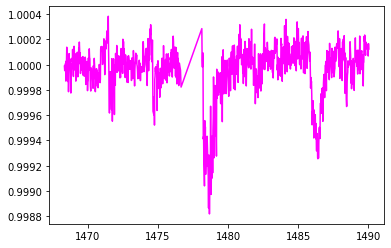

In [9]:
eleanor.TargetData.custom_aperture(star_data, shape='rectangle', h=14, w=4.5)
plt.plot(star_data.time[q], star_data.corr_flux[q]/np.nanmedian(star_data.corr_flux[q]), 'magenta', label='Corrected')

notes:

```star = eleanor.Source(tic=bucket.TIC_ID[i],sector=bucket.sector[i])
 data = eleanor.TargetData(star, height=13, width=13, bkg_size=31, do_psf=True, do_pca=True)```
 
 could be a possible idea of how to download raw `eleanor` files and operate saturated star analysis on that.

In [10]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


## Applying MAD cuts

In [11]:
from analysis_tools_cython import *
import data
import loaders
from astropy.stats import sigma_clip,sigma_clipped_stats
from astropy.table import Table
from astropy.time import Time

In [12]:
bad_times = data.load_bad_times()
bad_times = bad_times - 2457000
mad_df = data.load_mad()

In [13]:
sec = 6
cam = 1
mad_arr = mad_df.loc[:len(star_data.time[q])-1, f"{sec}-{cam}"]

In [14]:
clip = 3
sig_test = sigma_clip(mad_arr,sigma=clip,masked=False)
med_sig_clip = np.nanmedian(sig_test)
rms_sig_clip = np.nanstd(sig_test)


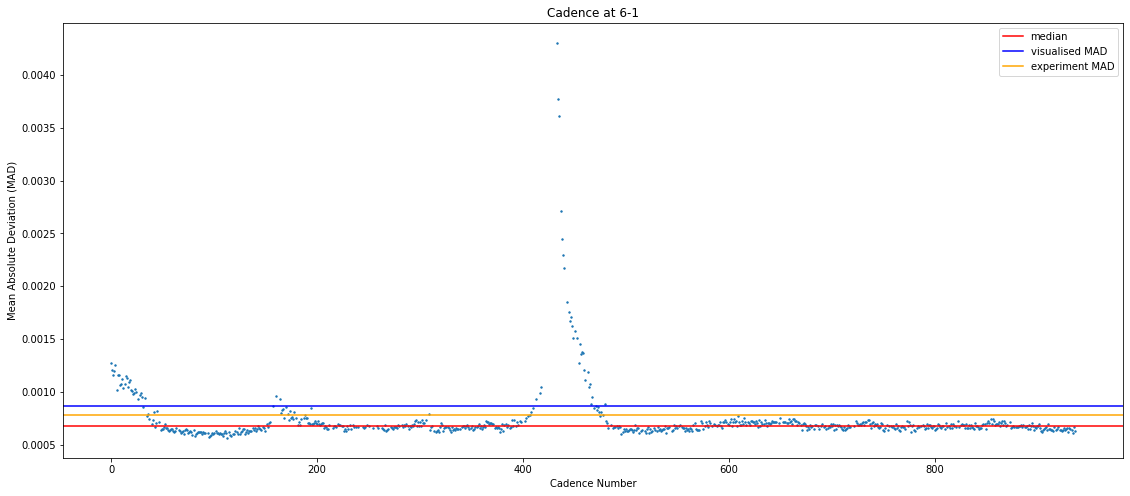

In [15]:
fig,ax = plt.subplots(figsize=(19,8))
ax.scatter(range(0,len(star_data.time[q])), mad_arr, s=2)
ax.axhline(np.nanmedian(mad_arr), c='r',label='median')
ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
ax.axhline(med_sig_clip + clip*rms_sig_clip, c='orange',label='experiment MAD')
ax.set_xlabel('Cadence Number')
ax.set_ylabel('Mean Absolute Deviation (MAD)')
ax.set_title(f'Cadence at {sec}-{cam}')
ax.legend()
plt.show()

In [16]:
mad_cut = mad_arr.values<(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950])) # removes any values above threshold
mad_cut2 = mad_arr.values<(med_sig_clip + clip*(rms_sig_clip))

In [17]:
mask = np.ones_like(star_data.time[q], dtype=bool)
for i in bad_times:
    newchunk = (star_data.time[q]<i[0])|(star_data.time[q]>i[1])
    mask = mask & newchunk

In [18]:
#(star_data[(star_data.quality == 0) & mask & mad_cut])

In [19]:
df = pd.DataFrame(data=[star_data.quality[q],star_data.corr_flux[q],star_data.time[q]]).T

In [20]:
cols = ['quality','corr_flux','time']
df.columns = cols

In [21]:
df.normalised_corr_flux = normalise_lc(df.corr_flux)

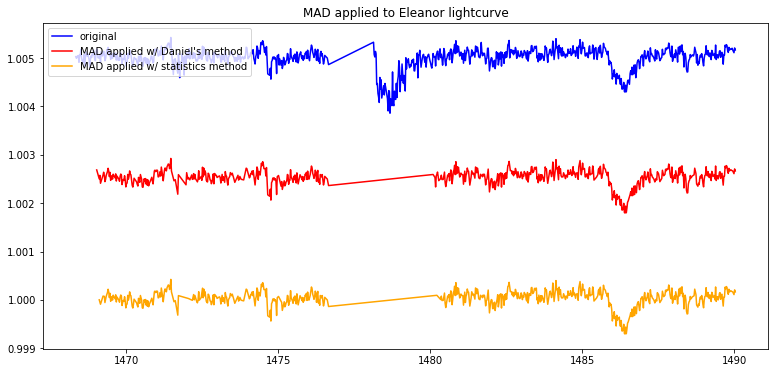

In [116]:
plt.figure(figsize=(13,6))
plt.plot(df.time[(df.quality==0)],df.normalised_corr_flux[(df.quality==0)] + 0.005,c='blue',label='original')
plt.plot(df.time[(df.quality==0) & mask & mad_cut],df.normalised_corr_flux[(df.quality==0) & mask & mad_cut] + 0.0025,c='red',label='MAD applied w/ Daniel\'s method')
plt.plot(df.time[(df.quality==0) & mask & mad_cut2],df.normalised_corr_flux[(df.quality==0) & mask & mad_cut2],c='orange',label='MAD applied w/ statistics method')
plt.title('MAD applied to Eleanor lightcurve')
#plt.ylim([0.9985,1.0006])
plt.legend(loc='upper left')
plt.show()

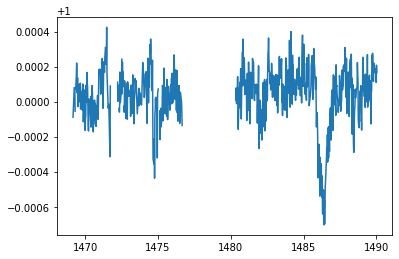

In [123]:
mad_cut_df = pd.DataFrame(data=[df.time[(df.quality==0) & mask & mad_cut2],df.normalised_corr_flux[(df.quality==0) & mask & mad_cut],df.quality[(df.quality==0) & mask & mad_cut]]).T
plt.plot(mad_cut_df.time,mad_cut_df.corr_flux)

In [125]:
mad_cut_df

,time,corr_flux,quality
31,NaN,1.000187,0.0
35,1469.116681,1.000002,0.0
36,NaN,1.000075,0.0
37,1469.158348,0.999911,0.0
40,1469.220848,1.000041,0.0
...,...,...,...
931,1489.908222,1.000179,0.0
933,1489.949888,1.000166,0.0
934,1489.991554,1.000109,0.0
935,1490.012387,1.000208,0.0


In [117]:
#mad_cut_df.dropna(inplace=True)

---

## Automated Search - `single_analysis_xrp.py`

In [118]:
from analysis_tools_cython import *

In [124]:
table = Table.from_pandas(mad_cut_df)
table

time,corr_flux,quality
float64,float64,float64
--,1.0001865179697393,0.0
1469.1166814577352,1.000002034742747,0.0
--,1.0000748244100288,0.0
1469.1583480907243,0.9999107628097476,0.0
1469.2208480453587,1.0000412545803308,0.0
1469.2416813641646,1.0000789307292213,0.0
--,1.0001390773909482,0.0
1469.2833480013908,1.0000733273309241,0.0
1469.3041813193772,0.9999447722185378,0.0


In [120]:
def fill_with_nan(t):
    arr = t.as_array()
    arr_list = arr.tolist()
    arr = np.array(arr_list)
    arr[np.equal(arr, None)] = np.nan
    arr = np.array(arr.tolist())
    return Table(arr)

In [103]:
table = fill_with_nan(table)
table

col0,col1,col2
float64,float64,float64
nan,1.0001865179697393,0.0
1469.1166814577352,1.000002034742747,0.0
nan,1.0000748244100288,0.0
1469.1583480907243,0.9999107628097476,0.0
1469.2208480453587,1.0000412545803308,0.0
1469.2416813641646,1.0000789307292213,0.0
nan,1.0001390773909482,0.0
1469.2833480013908,1.0000733273309241,0.0
1469.3041813193772,0.9999447722185378,0.0


0.020833191576912213
Maximum transit chance:
   Time = 1474.7 days.
   Duration = 0.12 days.
   T = -7.3
   T/sigma = -3.9
Transit depth = -0.000362
[5.065789015988075e-07, 5.229241793460955e-07]
Asym score: 0.9687
maybeTransit


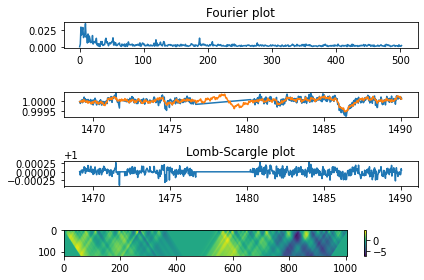

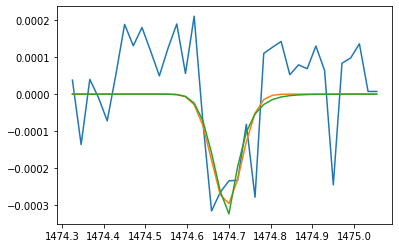

In [122]:
timestep = calculate_timestep(table) # median value of time differences between data points
print(timestep)
t, flux, quality, real = clean_data(table)
N = len(t) # length of data (time)
ones = np.ones(N) # array of ones

flux = normalise_flux(flux) # normalised flux - need to(?)

# periodic noise removal with fourier
filteredflux = fourier_filter(flux, 8)
A_mag = np.abs(np.fft.rfft(flux))
periodicnoise = flux - filteredflux
sigma = flux.std()

# periodic noise removal with lomb-scargle
flux_ls = np.copy(flux)
lombscargle_filter(t, flux_ls, real, 0.05) # no output for kepler??
periodicnoise_ls = flux - flux_ls # removing periodic noise = flux - flux_ls ( the cleaned lc) 
flux_ls = flux_ls * real # real: interpolated data assumed to be real

T1 = test_statistic_array(filteredflux, 60) # fourier test statistic
T = test_statistic_array(flux_ls, 60) # lomb-scargle test statistic
data = nonzero(T) # all non zeroes

# Find minimum test statistic value, and its location.
m, n = np.unravel_index(T.argmin(), T.shape) # gives index of minimum T (m), and index of minimum T (n) - the element of the shape (so here, 1145) 
minT = T[m, n] # T test result - the most negative value of T - strongest event in lightcurve.
minT_time = t[n] # period of transit
minT_duration = m * timestep # duration of transit
print("Maximum transit chance:")
print("   Time =", round(minT_time, 2), "days.") # 
print("   Duration =", round(minT_duration, 2), "days.") # box duration of transit
print("   T =", round(minT, 1)) # minimum test statistic (signal)
print("   T/sigma =", round(minT / data.std(), 1)) # strongest signal / std of all n and w considered

trans_start = n - math.floor((m - 1) / 2) # (1145-(1-1)/2): half width - math.floor rounds down
trans_end = trans_start + m 
print("Transit depth =", round(flux[trans_start:trans_end].mean(), 6))

# Transit shape calculation
if n - 3 * m >= 0 and n + 3 * m < N: # m: width of point(s) in lc. first part: 3 transit widths away from first data point. last part: not more than 3 transit widths away. 
    t2 = t[n - 3 * m:n + 3 * m] #time array
    x2 = flux_ls[n - 3 * m:n + 3 * m] #flux array
    q2 = quality[n - 3 * m:n + 3 * m] 
    background = (sum(x2[:1 * m]) + sum(x2[5 * m:])) / (2 * m)
    x2 -= background 
    paramsgauss = single_gaussian_curve_fit(t2, -x2) #gaussian curve
    y2 = -gauss(t2, *paramsgauss) # simple gaussian model fit
    paramscomet = comet_curve_fit(t2, -x2)
    w2 = -comet_curve(t2, *paramscomet) # modified gaussian model fit with exponential tail

    scores = [score_fit(x2, fit) for fit in [y2, w2]]
    print(scores)
    print("Asym score:", round(scores[0] / scores[1], 4))

    #qual_flags = reduce(lambda a, b: a or b, q2)
    #print("Quality flags:", qual_flags)

# Classify events
asym, _, _ = calc_shape(m, n, t, flux) # plot 
print(classify(m, n, real, asym))

# Skip plotting if no graphical output set
# if args.n:
#     sys.exit()

# plt.xkcd()
fig1, axarr = plt.subplots(4)
axarr[0].plot(A_mag) # fourier plot
axarr[0].title.set_text('Fourier plot')
axarr[1].plot(t, flux + ones, t, periodicnoise_ls + ones) #
axarr[2].plot(t, flux_ls + ones) # lomb-scargle plot
axarr[2].title.set_text('Lomb-Scargle plot') 
cax = axarr[3].imshow(T)
axarr[3].set_aspect('auto')
fig1.colorbar(cax)

# params = double_gaussian_curve_fit(T)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
# T_test_nonzero = np.array(data)
# _,bins,_ = ax2.hist(T_test_nonzero,bins=100,log=True)
# y = np.maximum(bimodal(bins,*params),10)
# ax2.plot(bins,y)
try:
    ax2.plot(t2, x2, t2, y2, t2, w2)
 
except:
    pass

fig1.tight_layout()
plt.show()

